## Crack Detection using DL

#### Imports

In [52]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import os
from tensorflow.keras.applications import VGG16
from keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from keras.models import Sequential
from keras.layers import Dense

#### Data Preparation

In [7]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        if len(images)>3:
            break
    fig=plt.figure(figsize=(10,12))
    xrange=range(1,3)
    
    for img,x in zip(images,xrange):
        ax=fig.add_subplot(2,2,x)
        ax.imshow(img)
        ax.set_title(img.shape)

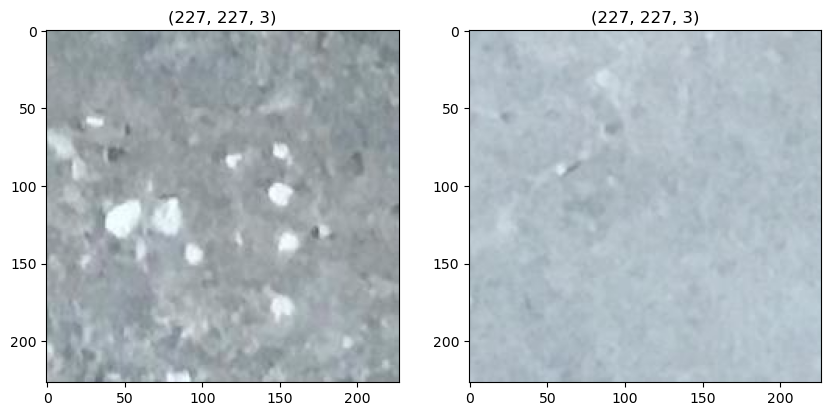

In [8]:
load_images('/kaggle/input/surface-crack-detection/Negative')

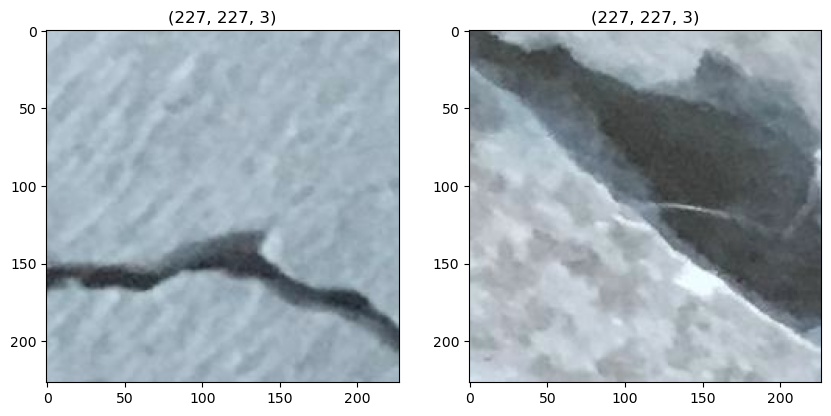

In [9]:
load_images('/kaggle/input/surface-crack-detection/Positive')

In [10]:
# Image generators

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory('../input/surface-crack-detection',
                                                     target_size=(150,150),
                                                     batch_size=64,
                                                     shuffle=True,
                                                     class_mode='binary',
                                                     subset='training') 

validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

validation_generator =  validation_datagen.flow_from_directory('../input/surface-crack-detection',
                                                                target_size=(150,150),
                                                                batch_size=64,
                                                                class_mode='binary',
                                                                subset='validation') 

Found 28000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.


#### Approach 1: VGG16

In [11]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [12]:
pretrained_model=VGG16(input_shape = (150, 150, 3), 
                        include_top = False, 
                        weights ='imagenet')


for layer in pretrained_model.layers:
     layer.trainable = False


In [13]:
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model_vgg = Model(pretrained_model.input, x) 


model_vgg.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [14]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [20]:
# defining a callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nEnough accuracy!")
            self.model.stop_training = True

In [21]:
callbacks = myCallback()

In [22]:
history = model_vgg.fit(train_generator,
                                  validation_data = validation_generator,
                                  epochs = 15,
                                  verbose = 1,
                                   callbacks=[callbacks])

Epoch 1/15
438/438 [==============================] - 68s 156ms/step - loss: 0.0095 - accuracy: 0.9974 - val_loss: 0.0156 - val_accuracy: 0.9962
Epoch 2/15
438/438 [==============================] - 65s 149ms/step - loss: 0.0088 - accuracy: 0.9980 - val_loss: 0.0186 - val_accuracy: 0.9955
Epoch 3/15
438/438 [==============================] - 68s 154ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.0116 - val_accuracy: 0.9969
Epoch 4/15
438/438 [==============================] - 67s 152ms/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.0150 - val_accuracy: 0.9960
Epoch 5/15
438/438 [==============================] - 68s 155ms/step - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.0146 - val_accuracy: 0.9963
Epoch 6/15
438/438 [==============================] - 65s 149ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0149 - val_accuracy: 0.9966
Epoch 7/15
438/438 [==============================] - 73s 166ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.0236 - val_ac

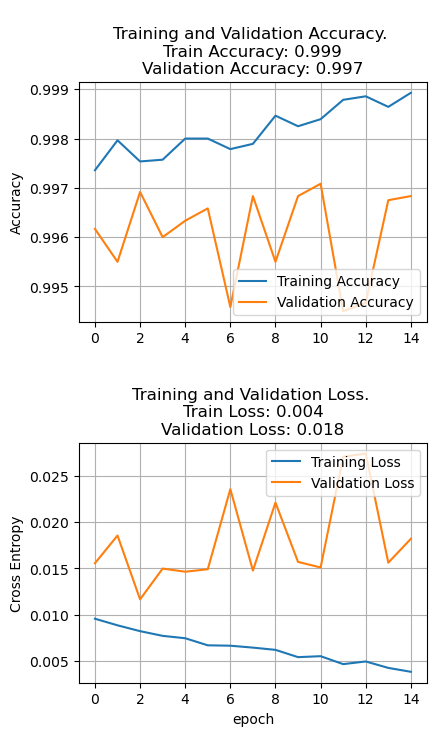

In [23]:
plot_history(history)

#### Approach 2: InceptionV3

In [39]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
     layer.trainable = False
        

87910968/87910968 [==============================] - 3s 0us/step


In [40]:
last_layer = pre_trained_model.get_layer('mixed7') 
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x)
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
    
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 74, 74, 32)  96          ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                            

In [43]:
callbacks = myCallback()

history = model.fit(train_generator,
            validation_data = validation_generator,
            epochs = 5,
            verbose = 1,
            callbacks=[callbacks])

Epoch 1/5
438/438 [==============================] - 71s 163ms/step - loss: 0.0173 - accuracy: 0.9973 - val_loss: 0.0127 - val_accuracy: 0.9977
Epoch 2/5
438/438 [==============================] - 69s 157ms/step - loss: 0.0159 - accuracy: 0.9974 - val_loss: 0.0405 - val_accuracy: 0.9958
Epoch 3/5
438/438 [==============================] - 69s 158ms/step - loss: 0.0169 - accuracy: 0.9977 - val_loss: 0.0137 - val_accuracy: 0.9982
Epoch 4/5
438/438 [==============================] - 64s 147ms/step - loss: 0.0148 - accuracy: 0.9978 - val_loss: 0.0542 - val_accuracy: 0.9956
Epoch 5/5
438/438 [==============================] - 73s 166ms/step - loss: 0.0111 - accuracy: 0.9983 - val_loss: 0.1029 - val_accuracy: 0.9893


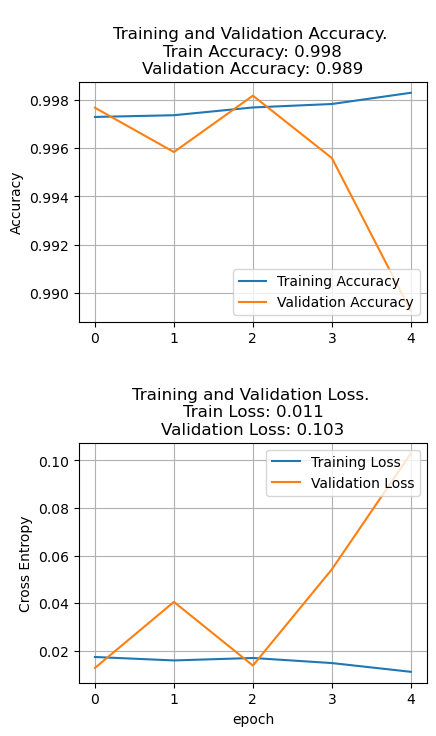

In [44]:
plot_history(history)

#### Approach 3: ResNet50

In [45]:
# Image generators for ResNet50

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory('../input/surface-crack-detection',
                                                     target_size=(224,224),
                                                     batch_size=64,
                                                     shuffle=True,
                                                     class_mode='binary',
                                                     subset='training') 

validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

validation_generator =  validation_datagen.flow_from_directory('../input/surface-crack-detection',
                                                                target_size=(224,224),
                                                                batch_size=64,
                                                                class_mode='binary',
                                                                subset='validation') 

Found 28000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.


In [57]:
model_res50 = Sequential()

model_res50.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet'
    ))

model_res50.add(Dense(1, activation='sigmoid'))

model_res50.layers[0].trainable = False 

model_res50.summary()

steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_9 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [60]:
callbacks = myCallback()

model_res50.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


history = model_res50.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/5
438/438 [==============================] - 121s 267ms/step - loss: 0.5341 - accuracy: 0.8722 - val_loss: 0.4564 - val_accuracy: 0.8834
Epoch 2/5
438/438 [==============================] - 114s 261ms/step - loss: 0.3730 - accuracy: 0.9227 - val_loss: 0.3624 - val_accuracy: 0.8994
Epoch 3/5
438/438 [==============================] - 113s 258ms/step - loss: 0.2968 - accuracy: 0.9325 - val_loss: 0.3139 - val_accuracy: 0.8947
Epoch 4/5
438/438 [==============================] - 120s 274ms/step - loss: 0.2515 - accuracy: 0.9383 - val_loss: 0.2858 - val_accuracy: 0.8933
Epoch 5/5
438/438 [==============================] - 116s 264ms/step - loss: 0.2221 - accuracy: 0.9420 - val_loss: 0.2608 - val_accuracy: 0.9020


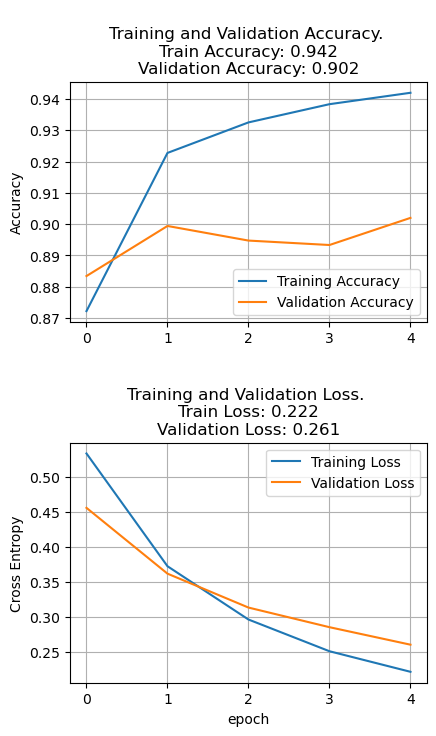

In [61]:
plot_history(history)